In [1]:
# project: p6
# submitter: tjbuck
# partner: none
# hours: 20

In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import sqlite3
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder
import numpy as np
import rasterio
from rasterio.mask import mask
plt.rcParams["font.size"] = 14

In [3]:
#Q1: How many counties are in Wisconsin?

counties = gpd.read_file("counties.geojson")
len(counties)

72

<AxesSubplot:>

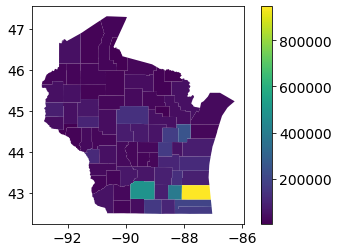

In [4]:
#Q2: What is the population of each county in WI?

counties.plot(column = "POP100", legend = True)

In [5]:
conn = sqlite3.connect("counties_tracts.db")
arealand = pd.read_sql("""SELECT * FROM counties""", conn)
counties["AREALAND"] = arealand["AREALAND"]
train, test = train_test_split(counties, random_state=320, test_size=0.25)

In [6]:
#Q3: What are the counties in the test dataset?

list(test["NAME"])

['Kewaunee County',
 'Calumet County',
 'Adams County',
 'Eau Claire County',
 'Milwaukee County',
 'Ashland County',
 'Wood County',
 'Dodge County',
 'Sauk County',
 'Clark County',
 'Pepin County',
 'Taylor County',
 'Iron County',
 'Outagamie County',
 'Florence County',
 'Oneida County',
 'Pierce County',
 'Grant County']

In [7]:
#Q4: How much variance in the POP100 can a LinearRegression model explain based only on AREALAND?

model = LinearRegression()
model.fit(train[["AREALAND"]], train["POP100"])
model.score(test[["AREALAND"]], test["POP100"])

0.022002661530554857

In [8]:
#Q5: What is the predicted population of a county with 500 square miles of area, according to the model?

sqmiles = 500*2.59*1000000
model.predict(pd.DataFrame({"test": [0, 1, sqmiles]}))[2]

/home/thoma/.local/lib/python3.8/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- test
Feature names seen at fit time, yet now missing:
- AREALAND

  warnings.warn(message, FutureWarning)


82032.53073541154

In [9]:
hu100 = pd.read_sql("""SELECT COUNTY, SUM(HU100) as HU100 FROM tracts GROUP BY COUNTY""", conn)
hu100.to_sql("hu100", conn, if_exists = "replace", index = False)
final = pd.read_sql("""SELECT * from counties INNER JOIN hu100 ON counties.COUNTY = hu100.COUNTY""", conn)
counties["HU100"] = final["HU100"]
train1, test1 = train_test_split(counties, random_state=320, test_size=0.25)

In [10]:
#Q6: What are the counties in the test dataset?

list(test1["NAME"])

['Kewaunee County',
 'Calumet County',
 'Adams County',
 'Eau Claire County',
 'Milwaukee County',
 'Ashland County',
 'Wood County',
 'Dodge County',
 'Sauk County',
 'Clark County',
 'Pepin County',
 'Taylor County',
 'Iron County',
 'Outagamie County',
 'Florence County',
 'Oneida County',
 'Pierce County',
 'Grant County']

In [11]:
#Q7: What are the HU100 values for the counties in the train dataset?

hu100_dict = {}
for row in train1.itertuples():
    hu100_dict[row.NAME] = row.HU100
    
hu100_dict

{'Walworth County': 51531,
 'Marquette County': 9896,
 'Racine County': 82164,
 'Waupaca County': 25396,
 'Lincoln County': 16784,
 'Washburn County': 12979,
 'Door County': 23966,
 'Waukesha County': 160864,
 'Sheboygan County': 50766,
 'La Crosse County': 48402,
 'Langlade County': 12360,
 'Marathon County': 57734,
 'Jefferson County': 35147,
 'Price County': 11120,
 'Vilas County': 25116,
 'Columbia County': 26137,
 'Ozaukee County': 36267,
 'Fond du Lac County': 43910,
 'Crawford County': 8802,
 'Lafayette County': 7230,
 'Green County': 15856,
 'Marinette County': 30379,
 'Vernon County': 13720,
 'Douglas County': 22825,
 'Rock County': 68422,
 'Iowa County': 10719,
 'Dane County': 216022,
 'Bayfield County': 12999,
 'Polk County': 24248,
 'Trempealeau County': 12619,
 'Brown County': 104371,
 'Washington County': 54695,
 'Chippewa County': 27185,
 'Oconto County': 23537,
 'Richland County': 8868,
 'Portage County': 30054,
 'Sawyer County': 15975,
 'Menominee County': 2253,
 'Barr

In [12]:
#Q8: How much variance in the POP100 can a LinearRegression model explain based only on HU100?

m8 = LinearRegression()
var8 = cross_val_score(m8,train1[["HU100"]],train1["POP100"], cv = 5)
var8.mean()

0.9652534544116037

In [13]:
#Q9: What is the standard deviation of the cross validation scores from Q7?

var8.std()

0.03704265206670459

In [14]:
#Q10: What is the formula relating POP100 and HU100?

m8.fit(train1[["HU100"]], train1["POP100"])
m8.score(test1[["HU100"]], test1["POP100"])
f"POP100 = {round(m8.coef_[0],2)}*HU100 + {round(m8.intercept_,2)}"

'POP100 = 2.39*HU100 + -7910.46'

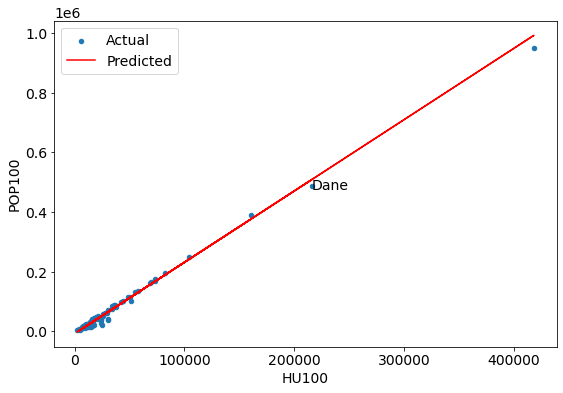

In [15]:
#Q11: What is the relationship between HU100 and POP100, visually?

m = round(m8.coef_[0],2)
y_int = round(m8.intercept_,2)
x = int(counties[counties["NAME"] == "Dane County"]["HU100"])
y = int(counties[counties["NAME"] == "Dane County"]["POP100"])
fig,ax = plt.subplots(figsize = (9,6))
counties.plot.scatter(ax = ax, x = "HU100", y = "POP100", label = "Actual")
plt.plot(counties["HU100"], m*counties["HU100"] + y_int, color = "red", label = "Predicted")
ax.text(x, y, "Dane", va="center", ha="left")
ax.legend()

In [16]:
#Q12: How many numbers in matrix A are between 2 and 5 (inclusive)?

A = np.array([
    [0,0,5,8,4],
    [1,2,4,0,3],
    [2,4,0,9,2],
    [3,5,2,1,1],
    [0,5,0,1,0]
])

len(A[(A <= 5) & (A >= 2)])

12

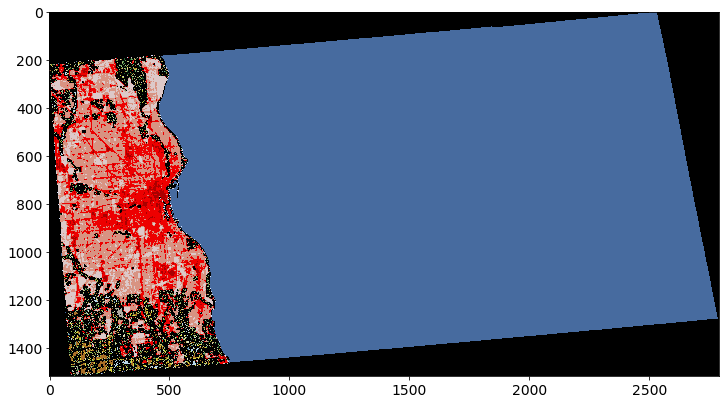

In [17]:
#Q13: How does Milwaukee County look?

from matplotlib.colors import ListedColormap

c = np.zeros((256,3))
c[0] = [0.00000000000, 0.00000000000, 0.00000000000]
c[11] = [0.27843137255, 0.41960784314, 0.62745098039]
c[12] = [0.81960784314, 0.86666666667, 0.97647058824]
c[21] = [0.86666666667, 0.78823529412, 0.78823529412]
c[22] = [0.84705882353, 0.57647058824, 0.50980392157]
c[23] = [0.92941176471, 0.00000000000, 0.00000000000]
c[24] = [0.66666666667, 0.00000000000, 0.00000000000]
c[31] = [0.69803921569, 0.67843137255, 0.63921568628]
c[41] = [0.40784313726, 0.66666666667, 0.38823529412]
c[42] = [0.10980392157, 0.38823529412, 0.18823529412]
c[43] = [0.70980392157, 0.78823529412, 0.55686274510]
c[51] = [0.64705882353, 0.54901960784, 0.18823529412]
c[52] = [0.80000000000, 0.72941176471, 0.48627450980]
c[71] = [0.88627450980, 0.88627450980, 0.75686274510]
c[72] = [0.78823529412, 0.78823529412, 0.46666666667]
c[73] = [0.60000000000, 0.75686274510, 0.27843137255]
c[74] = [0.46666666667, 0.67843137255, 0.57647058824]
c[81] = [0.85882352941, 0.84705882353, 0.23921568628]
c[82] = [0.66666666667, 0.43921568628, 0.15686274510]
c[90] = [0.72941176471, 0.84705882353, 0.91764705882]
c[95] = [0.43921568628, 0.63921568628, 0.72941176471]
custom_cmap = ListedColormap(c)

land = rasterio.open("zip://../p6/land.zip!wi.tif")
mil = counties[counties["NAME"] == "Milwaukee County"]
matrix, _ = mask(land, mil.to_crs(land.crs)["geometry"], crop=True)
matrix = matrix[0]

fig, ax = plt.subplots(figsize=(12,12))
ax.imshow(matrix, vmin=0, vmax=255, cmap=custom_cmap)

In [18]:
#Q14: What portion of Milwaukee County is "Open Water"?

total = matrix[matrix!=0]
water = total[total == 11] 
len(water)/len(total)

0.7963037455950543

In [19]:
cellcount_lst = []
for row in counties.itertuples():
    matrix, _ = mask(land, counties[counties["NAME"] == row.NAME].to_crs(land.crs)["geometry"], crop=True)
    matrix = matrix[0]
    high = matrix[matrix == 24]
    cellcount_lst.append(len(high))
counties["High Developed Cells in County"] = cellcount_lst

<AxesSubplot:xlabel='High Developed Cells in County', ylabel='POP100'>

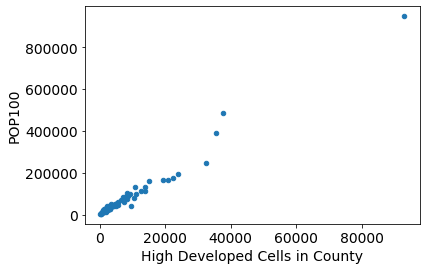

In [20]:
#Q15: What is the Relationship Between POP100 and developed_high?

fig,ax = plt.subplots()
counties.plot.scatter(ax = ax, x = "High Developed Cells in County", y = "POP100")

In [21]:
tracts = gpd.read_file("tracts.geojson")

In [22]:
q16_low = []
q16_med = []
q16_high = []
for row in tracts.itertuples():
    matrix, _ = mask(land, tracts[tracts["GEOID"] == row.GEOID].to_crs(land.crs)["geometry"], crop=True)
    matrix = matrix[0]
    low = matrix[matrix == 22]
    med = matrix[matrix == 23]
    high = matrix[matrix == 24]
    q16_low.append(len(low))
    q16_med.append(len(med))
    q16_high.append(len(high))
tracts["Developed Low"] = q16_low
tracts["Developed Med"] = q16_med
tracts["Developed High"] = q16_high

In [23]:
train_f, test_f = train_test_split(tracts, random_state=320)

In [24]:
m1 = LinearRegression()
score1 = cross_val_score(m1, train_f[["Developed Med"]], train_f["POP100"])
score1.mean()

0.3827922254716966

In [25]:
m2 = Pipeline([
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("lr", LinearRegression())
])
score2 = cross_val_score(m2, train_f[["Developed Med"]], train_f["POP100"])
score2.mean()

0.41621273220980004

In [26]:
cols = ["Developed Low", "Developed Med", "Developed High"]
m3 = Pipeline([
    ("poly", PolynomialFeatures(degree=2, include_bias=False)),
    ("lr", LinearRegression())
])
score3 = cross_val_score(m3, train_f[cols], train_f["POP100"])
score3.mean()

# I am using this model because:
# 1. It has a higher explained variance score than the previous models
# 2. Even though the standard deviation is slightly larger, it is only by a marginal amount compared to the other models and gaining over 3% explained variance is worth the trade off
# 3. It is slightly more complex, but adding these additional columns to the dataframe doesn't take much longer. It's also essentially 1 more line of code to create the model than the previous ones

0.4503306392821365

Text(0, 0.5, 'R^2 Score')

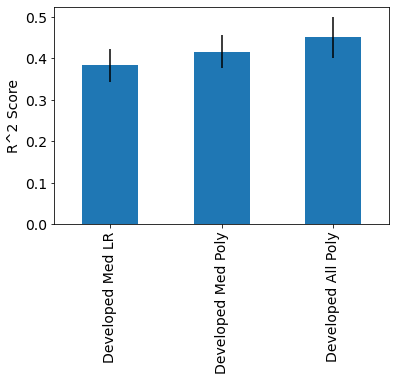

In [27]:
#Q16: How do the models you selected compare under cross validation?

avg = pd.Series({"Developed Med LR": score1.mean(), "Developed Med Poly": score2.mean(), "Developed All Poly": score3.mean()})
std = pd.Series({"Developed Med LR": score1.std(), "Developed Med Poly": score2.std(), "Developed All Poly": score3.std()})
ax = avg.plot.bar(yerr=std)
ax.set_ylabel("R^2 Score")

In [28]:
#Q17: How does your recommended model score against the test dataset?

final_score = cross_val_score(m3, test_f[cols], test_f["POP100"])
final_score.mean()

0.4037735663122235